## Goal 
In this assignment, you are challenged to build a multi-label classification model for detecting different types of toxic comments like threats, obscenity, insults, and identity-based hate. You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. You must create a model which predicts a probability of each type of toxicity for each comment.

Author: Yiming Jin(金一鸣)

### All the training were completed in the Google Colaboratory.
### Using Keras to set up the neural network,becasue Google Colaboratory dosen't have Multi-GPU,  I trained it via normal setting


In [1]:
import matplotlib.gridspec as grd
import seaborn as sns
sns.set()
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image as PILImage
# Keras
from keras.layers import (Dense, Input, Bidirectional, Activation, Dropout, Embedding, Flatten, CuDNNLSTM, 
                          Conv2D, MaxPool2D, concatenate, K, Reshape, LSTM) 
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from keras.preprocessing import text, sequence
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers
from keras.utils import multi_gpu_model
from IPython.display import Image # display images
import numpy as np 
import pandas as pd 
import os
os.chdir("drive/MorningStarProject")   #set the file path for running
# plots
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


Using TensorFlow backend.


In [0]:
train_data=pd.read_csv("toxic_comments.csv")

In [3]:
train_data.head

<bound method NDFrame.head of                       id                                       comment_text  \
0       0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1       000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2       000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3       0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4       0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   
5       00025465d4725e87  "\n\nCongratulations from me as well, use the ...   
6       0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK   
7       00031b1e95af7921  Your vandalism to the Matt Shirvington article...   
8       00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...   
9       00040093b2687caa  alignment on this subject and which are contra...   
10      0005300084f90edc  "\nFair use rationale for Image:Wonju.jpg\n\nT...   
11      00054a5e18b50d

### Detect if any null value in the columns

In [4]:
train_data.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

### The data are very clean.thank you for giving me the clean data

### Create training data and generate label for training data

In [0]:
X_train = train_data["comment_text"].values
Y_train=train_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

### looking through the content of the data

In [6]:
train_data[train_data.toxic==1].iloc[1,1]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

In [7]:
train_data[train_data.severe_toxic==1].iloc[1,1]

'Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!'

In [8]:
train_data[train_data.obscene==1].iloc[1,1]

"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!"

In [9]:
train_data[train_data.threat==1].iloc[1,1]

"I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms"

In [10]:
train_data[train_data.insult==1].iloc[1,1]

"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!"

In [11]:
train_data[train_data.identity_hate==1].iloc[1,1]

'A pair of jew-hating weiner nazi schmucks.'

### break down the target and show the frequency graph

#### count the toxic label

In [0]:
tox_labels = train_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].copy()
rowsums = tox_labels.sum(axis=1)
train_data['clean']=(rowsums==0)
tox_labels['clean']=train_data['clean'].copy()
x = tox_labels.sum().copy()

#### plot the graph and show heatmap for label association

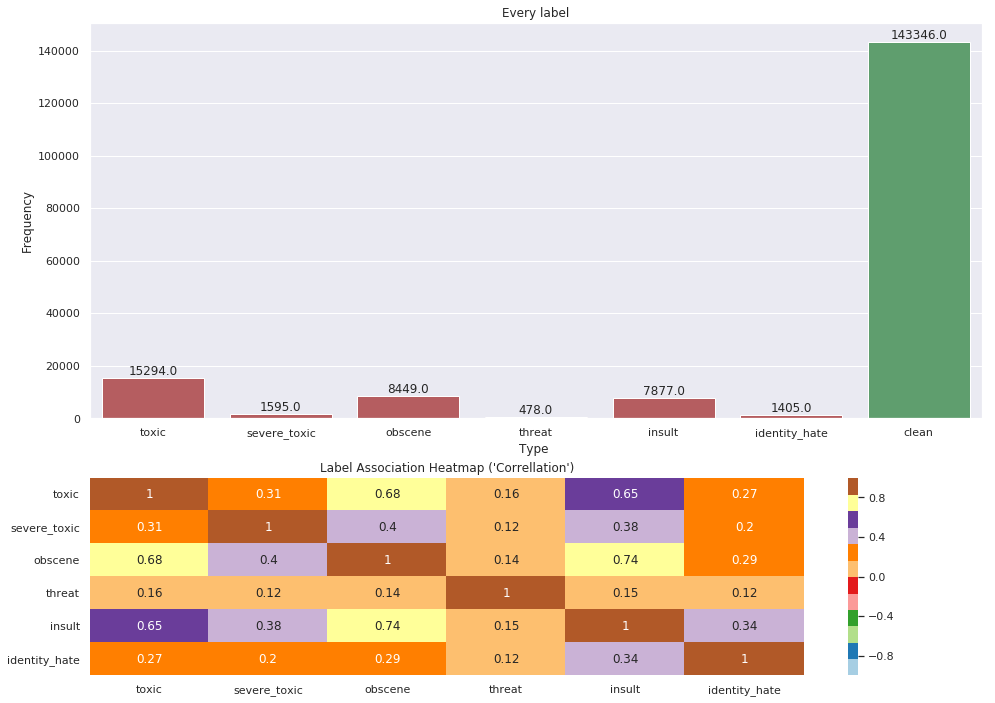

In [13]:
# create a 1 X 2 grid
plt.figure(figsize=(16,12))
gs = grd.GridSpec(2, 1, height_ratios=[2 , 1], wspace=0.1)
# bar plot
ax = plt.subplot(gs[0])
sns.barplot(x.index, x.values, palette=['r','r','r','r','r','r','g'], ax = ax)
plt.title("Every label")
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Type ', fontsize=12)
# adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    # corr matrix
corr = tox_labels[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].corr()

# heatmap
ax2 = plt.subplot(gs[1])
sns.heatmap(corr, cmap="Paired", ax = ax2,
            xticklabels=corr.columns.values, vmin = -1.0, vmax = 1.0,
            yticklabels=corr.columns.values, annot=True) 
plt.title("Label Association Heatmap ('Correllation')")
plt.show()

### show the word cloud for comment words

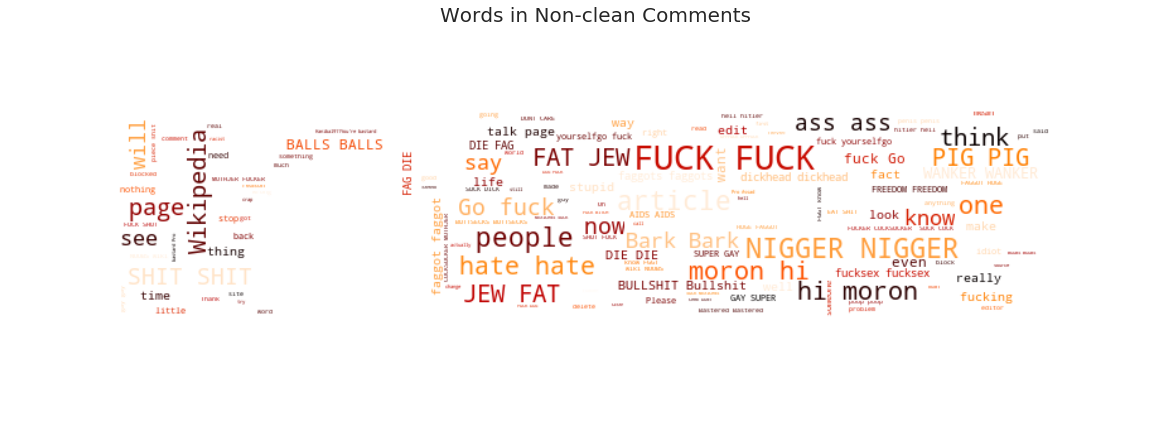

In [14]:
# stopwords
stopword=set(STOPWORDS)

# non-clean comments
clean_mask=np.array(PILImage.open("morningstar.jpg"))

# wordcloud for non-clean comments
subset=train_data[train_data.clean!=True]
texts=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=500,mask=clean_mask,stopwords=stopword,margin=5)
wc.generate(" ".join(texts))

plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words in Non-clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_heat' , random_state=17), interpolation='bilinear');

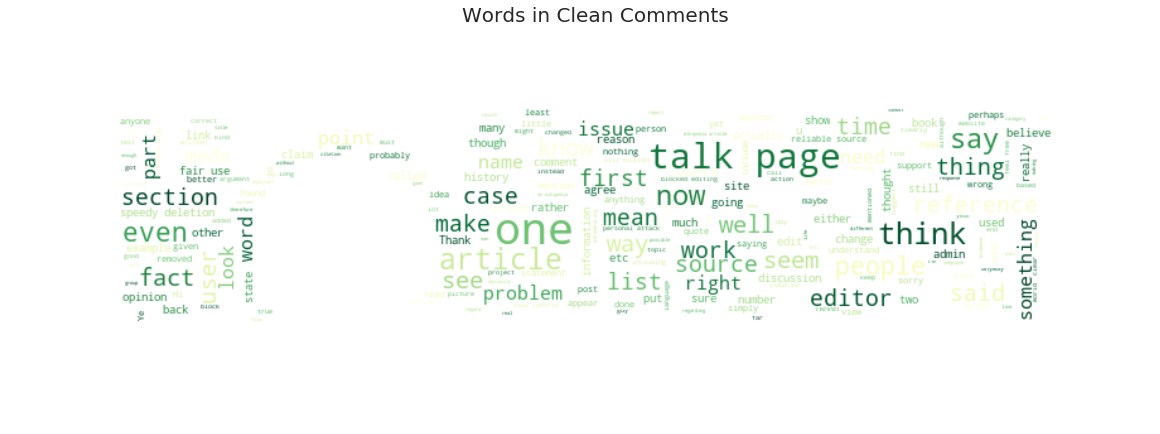

In [15]:
#clean comments
clean_mask=np.array(PILImage.open("morningstar.jpg"))

#wordcloud for clean comments
subset=train_data[train_data.clean==True]
texts=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=500,mask=clean_mask,stopwords=stopword,margin=5)
wc.generate(" ".join(texts))

plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'YlGn' , random_state=17), interpolation='bilinear');

## Set up a training neural network by using Keras
### 1. set up a embedding layer(using glove embedding)
### 2. using Bidirectional Recurrent Layer [ref.3]
### 3. set up a 2D Convolution Layer
### 4. 2D max pooling Layer
### 5. output Layer

#### Word Embedding

In [16]:
# embedding info
max_features = 210338
maxlen = 200
embed_size = 300

# tokenize
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)

# get word vectors
embeddings_index = {}
f = open("glove.42B.300d.txt",'rb')  # see reference 4
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
word_index = tokenizer.word_index
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i >= max_features: continue
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 1917494 word vectors.


#### Start set up training model by using Bidirectional and Conv2D model,I defined a callback by myself. The score is the individual AUCs of each predicted column

In [17]:
# average AUC callback
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['roc_val'] = score
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

            
def get_model():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], input_length=maxlen)(inp)
    x = Dropout(0.5)(x)    

    x = Bidirectional(CuDNNLSTM(300, return_sequences=True), merge_mode='sum')(x)
    x = Dropout(0.2)(x)
    x = Reshape((200, 300, 1))(x)

    x = Conv2D(100, kernel_size=(5,5), padding='valid', kernel_initializer='glorot_uniform')(x)
    x = MaxPool2D(pool_size=(5,5))(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(6, activation = "sigmoid",  kernel_regularizer=regularizers.l2(.00001))(x)
    
    parallel_model = Model(inputs = inp, outputs = x)
    parallel_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return parallel_model

model = get_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### we randomly choose 30% of the data as validation set, and 70% as training data set

In [18]:
# fit parameters
batch_size = 32
epochs = 5

# get test/train and ROC AUC callback
[X_tra, X_val, y_tra, y_val] = train_test_split(x_train, Y_train, test_size=.3, random_state=10)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

# fit
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 538s 5ms/step - loss: 0.0686 - acc: 0.9788 - val_loss: 0.0578 - val_acc: 0.9818

 ROC-AUC - epoch: 1 - score: 0.974296 

Epoch 2/5
111699/111699 [==============================] - 540s 5ms/step - loss: 0.0484 - acc: 0.9832 - val_loss: 0.0548 - val_acc: 0.9808

 ROC-AUC - epoch: 2 - score: 0.976490 

Epoch 3/5
111699/111699 [==============================] - 537s 5ms/step - loss: 0.0391 - acc: 0.9862 - val_loss: 0.0564 - val_acc: 0.9813

 ROC-AUC - epoch: 3 - score: 0.977837 

Epoch 4/5
111699/111699 [==============================] - 538s 5ms/step - loss: 0.0323 - acc: 0.9888 - val_loss: 0.0574 - val_acc: 0.9809

 ROC-AUC - epoch: 4 - score: 0.976375 

Epoch 5/5
111699/111699 [==============================] - 536s 5ms/step - loss: 0.0258 - acc: 0.9916 - val_loss: 0.0673 - val_acc: 0.9799

 ROC-AUC - epoch: 5 - score: 0.973467 



reference:  
1. http://colah.github.io/posts/2015-08-Understanding-LSTMs/
2. https://medium.com/@nehabhangale/toxic-comment-classification-models-comparison-and-selection-6c02add9d39f
3. Text Classification Improved by Integrating Bidirectional LSTM with Two-dimensional Max Pooling, https://arxiv.org/pdf/1611.06639.pdf
4. Download the pretrained vector representations for words. https://nlp.stanford.edu/projects/glove/
5. https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52557
